# Projeto de Redes Sociais

Cicero Tiago Carneiro Valentim

Lais Nascimento da Silva

Thalia Loiola da Silva

William Augusto Reis da Silva

### Bibliotecas

In [1]:
from graph_tool import centrality, clustering, PropertyMap
from graph_tool import Graph
from datetime import datetime
from netpixi.data.gt import *
from netpixi import render, peek
import matplotlib.pyplot as plt
import netpixi
import pandas as pd
import netpixi
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
!pip install openpyxl

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [3]:
df = pd.read_excel('netflix.xlsx')
df = df.dropna(subset=['Genre'])
df = df.reset_index()
df.head()

,index,Title,Genre,Tags,Languages,Series or Movie,Hidden Gem Score,Country Availability,Runtime,Director,...,Netflix Release Date,Production House,Netflix Link,IMDb Link,Summary,IMDb Votes,Image,Poster,TMDb Trailer,Trailer Site
0,0,Lets Fight Ghost,"Crime, Drama, Fantasy, Horror, Romance","Comedy Programmes,Romantic TV Comedies,Horror ...","Swedish, Spanish",Series,4.3,Thailand,< 30 minutes,Tomas Alfredson,...,2021-03-04,"Canal+, Sandrew Metronome",https://www.netflix.com/watch/81415947,https://www.imdb.com/title/tt1139797,A med student with a supernatural gift tries t...,205926.0,https://occ-0-4708-64.1.nflxso.net/dnm/api/v6/...,https://m.media-amazon.com/images/M/MV5BOWM4NT...,https://www.youtube.com/watch?v=LqB6XJix-dM,YouTube
1,1,HOW TO BUILD A GIRL,Comedy,"Dramas,Comedies,Films Based on Books,British",English,Movie,7.0,Canada,1-2 hour,Coky Giedroyc,...,2021-03-04,"Film 4, Monumental Pictures, Lionsgate",https://www.netflix.com/watch/81041267,https://www.imdb.com/title/tt4193072,"When nerdy Johanna moves to London, things get...",2838.0,https://occ-0-1081-999.1.nflxso.net/dnm/api/v6...,https://m.media-amazon.com/images/M/MV5BZGUyN2...,https://www.youtube.com/watch?v=eIbcxPy4okQ,YouTube
2,2,The Con-Heartist,"Comedy, Romance","Romantic Comedies,Comedies,Romantic Films,Thai...",Thai,Movie,8.6,Thailand,> 2 hrs,Mez Tharatorn,...,2021-03-03,NaN,https://www.netflix.com/watch/81306155,https://www.imdb.com/title/tt13393728,After her ex-boyfriend cons her out of a large...,131.0,https://occ-0-2188-64.1.nflxso.net/dnm/api/v6/...,https://m.media-amazon.com/images/M/MV5BODAzOG...,https://www.youtube.com/watch?v=md3CmFLGK6Y,YouTube
3,3,Gleboka woda,Drama,"TV Dramas,Polish TV Shows,Social Issue TV Dramas",Polish,Series,8.7,Poland,< 30 minutes,NaN,...,2021-03-03,NaN,https://www.netflix.com/watch/81307527,https://www.imdb.com/title/tt2300049,A group of social welfare workers led by their...,47.0,https://occ-0-2508-2706.1.nflxso.net/dnm/api/v...,https://m.media-amazon.com/images/M/MV5BMTc0Nz...,https://www.youtube.com/watch?v=5kyF2vy63r0,YouTube
4,4,Only a Mother,Drama,"Social Issue Dramas,Dramas,Movies Based on Boo...",Swedish,Movie,8.3,"Lithuania,Poland,France,Italy,Spain,Greece,Bel...",1-2 hour,Alf Sjöberg,...,2021-03-03,NaN,https://www.netflix.com/watch/81382068,https://www.imdb.com/title/tt0041155,An unhappily married farm worker struggling to...,88.0,https://occ-0-2851-41.1.nflxso.net/dnm/api/v6/...,https://m.media-amazon.com/images/M/MV5BMjVmMz...,https://www.youtube.com/watch?v=H0itWKFwMpQ,YouTube


In [4]:
df["Release Date"].describe()

count                    9196
unique                   4349
top       2018-09-21 00:00:00
freq                       20
first     1913-10-27 00:00:00
last      2021-11-12 00:00:00
Name: Release Date, dtype: object

### 1. Separando antes/depois do streaming

Não há uma data exata que separa o "antes" e o "depois" do streaming, uma vez ele já existe há quase duas décadas e até hoje está se popularizando. Por conveniência, vamos assumir que esse limiar é 2010, o ano em que a Netflix passou a oferecer [serviço de streaming fora dos Estados Unidos](https://pt.wikipedia.org/wiki/Netflix).

In [5]:
# 01 de janeiro de 2010
limiar = datetime.strptime('2010-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')

In [6]:
def get_before_after(whole_df, threshold=limiar):
    df = whole_df.copy(deep=True)
    df_before = df[df["Release Date"] < threshold]
    df_after  = df[df["Release Date"] >= threshold]
    return df_before, df_after

def get_series_movies(whole_df):
    df = whole_df.copy(deep=True)
    series = df[df["Series or Movie"] == "Series"]
    movies = df[df["Series or Movie"] == "Movie"]
    return series, movies

In [7]:
df_before, df_after = get_before_after(df)

In [8]:
series_before, movies_before = get_series_movies(df_before)
series_after, movies_after = get_series_movies(df_after)

In [9]:
t_series_before = series_before["Title"].tolist() # títulos de séries antes
t_series_after  = series_after["Title"].tolist()  # títulos de séries depois
t_movies_before = movies_before["Title"].tolist() # títulos de filmes antes
t_movies_after  = movies_after["Title"].tolist()  # títulos de filmes depois

In [10]:
def filter_graph(v_property:str, test_function):
    g = load_gt('projeto-one-mode-dicotomizado.net.gz')
    indexes_to_remove = []
    for v in g.vertices():
        if not test_function(g.vp[v_property][v]):
            indexes_to_remove.append(v)
    g.remove_vertex(indexes_to_remove)
    return g

In [11]:
gs_before = filter_graph('nome', lambda name: name in t_series_before)
gs_after = filter_graph('nome', lambda name: name in t_series_after)
gm_before = filter_graph('nome', lambda name: name in t_movies_before)
gm_after = filter_graph('nome', lambda name: name in t_movies_after)

In [12]:
save_gt(gs_before, 'gs_before-streaming.net.gz')
save_gt(gs_after, 'gs_after-streaming.net.gz')
save_gt(gm_before, 'gm_before-streaming.net.gz')
save_gt(gm_after, 'gm_after-streaming.net.gz')

In [13]:
!ls g[sm]*streaming.net.gz

gm_after-streaming.net.gz   gs_after-streaming.net.gz
gm_before-streaming.net.gz  gs_before-streaming.net.gz


### 1.1 Antes do Streaming

In [14]:
def with_scores(source_df, graph_df):
    # recebe como argumento um dataframe com todas as colunas e um dataframe obtido a partir do grafo
    source_df = source_df.copy()
    graph_df = graph_df.copy()
    
    # cria um novo dataframe com as colunas ["reputação", "nome"]
    columns = { "Rotten Tomatoes Score": "reputacao", "Title": "nome" }
    df_scores = source_df[list(columns.keys())].rename(columns=columns)
    
    # garante que os tipos são compatíveis entre as duas
    df_scores.nome = df_scores.nome.astype(str, copy=False)
    graph_df.nome  = graph_df.nome.astype(str, copy=False)
    graph_df.id    = graph_df.id.astype(int, copy=False)
    
    # faz uma limpeza simples de valores ausentes e seta o index pra coluna comum dos dois DFs
    df_scores = df_scores.drop_duplicates(subset=['nome'], keep=False)
    df_scores = df_scores.dropna()
    df_scores = df_scores.set_index('nome')
    
    # faz um 'join' dos dois DFs em relação à coluna comum (nome)
    graph_df = graph_df.set_index('nome')
    graph_df = graph_df.join(df_scores, how='left')
    graph_df = graph_df.reset_index()
    graph_df = graph_df.dropna(subset=['reputacao'])
    
    return graph_df

In [15]:
def with_net_parameters(graph):
    # calculo clustering coefficient
    c = clustering.local_clustering(graph)
    
    # calculo betweenness
    bc, _ = centrality.betweenness(graph)
    
    # calculo degree
    d = degree_gt(graph)
    
    graph.vp['betweenness'] = bc
    graph.vp['clustering'] = c
    graph.vp['degree'] = d
    
    return graph

In [16]:
gs_before = with_net_parameters(gs_before)
gm_before = with_net_parameters(gm_before)

In [17]:
df_series_before = pd.DataFrame({k: list(v) for k, v in gs_before.vp.items()})
df_movies_before = pd.DataFrame({k: list(v) for k, v in gm_before.vp.items()})

In [18]:
df_series_before.head()

,id,nome,_x,_y,betweenness,clustering,degree
0,0,Lets Fight Ghost,-1.436253,77.806371,0.0,1.0,0.007264
1,36,Alice,688.094045,-289.814468,0.0,0.0,0.000000
2,67,The Last Bastion,749.457179,-514.628824,0.0,0.0,0.000000
3,82,Sisyphus,196.021393,-761.412208,0.0,0.0,0.000000
4,107,Wheel of Fortune,-1066.706881,355.992201,0.0,0.0,0.000000


In [19]:
df_movies_before.head()

,id,nome,_x,_y,betweenness,clustering,degree
0,4,Only a Mother,698.456925,1632.287651,0.00000,0.000000,0.000000
1,5,Snowroller,807.543769,1008.637190,0.00000,0.000000,0.000000
2,6,The Invisible,55.645344,122.529907,0.00018,0.711688,0.023363
3,7,The Simple Minded Murderer,-1144.111152,-437.080844,0.00000,0.000000,0.000000
4,10,I,81.874520,73.708312,0.00000,1.000000,0.013767


In [20]:
sbws = with_scores(source_df=series_before, graph_df=df_series_before) # series before w/ scores
mbws = with_scores(source_df=movies_before, graph_df=df_movies_before) # movies before w/ scores

In [21]:
sbws.head()

,nome,id,_x,_y,betweenness,clustering,degree,reputacao
0,Lets Fight Ghost,0,-1.436253,77.806371,0.0,1.0,0.007264,98.0
1,Alice,36,688.094045,-289.814468,0.0,0.0,0.000000,75.0
5,Dont be the First one,126,816.800716,-755.600107,0.0,0.0,0.000000,78.0
7,Alone,166,-992.102381,-893.824030,0.0,0.0,0.000000,61.0
11,Im Home,196,62.479047,63.901600,0.0,1.0,0.029056,52.0


In [22]:
mbws.head()

,nome,id,_x,_y,betweenness,clustering,degree,reputacao
2,The Invisible,6,55.645344,122.529907,0.00018,0.711688,0.023363,20.0
3,The Simple Minded Murderer,7,-1144.111152,-437.080844,0.00000,0.000000,0.000000,92.0
4,I,10,81.874520,73.708312,0.00000,1.000000,0.013767,52.0
5,Comrades: Almost a Love Story,16,1413.097246,44.633800,0.00000,0.000000,0.000000,89.0
6,The Closet,17,1071.153342,-1052.400263,0.00000,0.000000,0.000000,85.0


### 1.2 Depois do Streaming

In [23]:
gs_after = with_net_parameters(gs_after)
gm_after = with_net_parameters(gm_after)

In [24]:
df_series_after = pd.DataFrame({k: list(v) for k, v in gs_after.vp.items()})
df_movies_after = pd.DataFrame({k: list(v) for k, v in gm_after.vp.items()})

In [25]:
df_series_after.head()

,id,nome,_x,_y,betweenness,clustering,degree
0,3,Gleboka woda,-62.084147,-830.782865,0.0,0.0,0.0
1,13,Girls und Panzer das Finale,1229.294831,985.860508,0.0,0.0,0.0
2,14,The Coroner,1176.876628,390.956114,0.0,0.0,0.0
3,15,Brave New World,1511.473682,-249.108707,0.0,0.0,0.0
4,29,Years and Years,-1381.350622,119.680219,0.0,0.0,0.0


In [26]:
df_movies_after.head()

,id,nome,_x,_y,betweenness,clustering,degree
0,1,HOW TO BUILD A GIRL,-229.729180,1039.631642,0.0,0.0,0.000000
1,2,The Con-Heartist,854.216640,357.749654,0.0,0.0,0.000000
2,8,To Kill a Child,477.886939,1357.210557,0.0,0.0,0.000000
3,9,Joker,-723.304606,1483.995708,0.0,0.0,0.000000
4,11,Harrys Daughters,96.413293,74.948004,0.0,1.0,0.000681


In [27]:
saws = with_scores(source_df=series_after, graph_df=df_series_after) # series after w/ scores
maws = with_scores(source_df=movies_after, graph_df=df_movies_after) # movies after w/ scores

In [55]:
print(sbws.shape)
print(saws.shape)
print(mbws.shape)
print(maws.shape)

(87, 8)
(61, 8)
(2073, 8)
(3045, 8)


In [56]:
saws.head()

,nome,id,_x,_y,betweenness,clustering,degree,reputacao
20,Ace Attorney,162,69.000390,129.286482,3.078296e-04,0.666102,0.032573,66.0
23,Lara,175,-1185.431314,-151.746590,0.000000e+00,0.000000,0.000000,82.0
62,Sweet Home,352,-1037.428269,721.665178,0.000000e+00,0.000000,0.000000,80.0
77,Detention,456,41.970713,105.062297,6.740289e-08,0.969697,0.006515,41.0
83,Godzilla,498,84.384109,88.369955,0.000000e+00,1.000000,0.004343,80.0


In [57]:
maws.head()

,nome,id,_x,_y,betweenness,clustering,degree,reputacao
0,HOW TO BUILD A GIRL,1,-229.729180,1039.631642,0.0,0.0,0.000000,79.0
4,Harrys Daughters,11,96.413293,74.948004,0.0,1.0,0.000681,96.0
6,Trial by Fire,26,-692.380026,-1411.460985,0.0,0.0,0.000000,61.0
9,Framing John DeLorean,34,208.197817,-1210.457887,0.0,0.0,0.000000,90.0
11,Paths of the Soul,40,26.661152,-1401.168557,0.0,0.0,0.000000,94.0


### 2 Plots dos gráficos

In [58]:
sns.set()

#### 2.1 Antes do Streaming

In [75]:
sb = sbws[sbws['betweenness'] > 0]
mb = mbws[mbws['betweenness'] > 0]

In [76]:
print("series.shape:", sb.shape)
print("movies.shape:", mb.shape)

series.shape: (7, 8)
movies.shape: (231, 8)


In [77]:
sb.head()

,nome,id,_x,_y,betweenness,clustering,degree,reputacao
21,Astro Boy,325,84.847303,48.175259,0.000085,0.833846,0.062954,50.0
73,Connected,1019,71.185396,109.434319,0.000027,0.600000,0.014528,73.0
113,Twice Upon A Time,1985,64.693787,43.624974,0.001674,0.565355,0.162228,91.0
149,Paprika,3959,42.883935,86.003663,0.000652,0.630108,0.075061,84.0
150,Yu Yu Hakusho: Ghost Files,3976,48.186212,52.837585,0.001968,0.531784,0.186441,78.0


In [78]:
mb.head()

,nome,id,_x,_y,betweenness,clustering,degree,reputacao
2,The Invisible,6,55.645344,122.529907,0.000180,0.711688,0.023363,20.0
25,The Shadow,89,67.704799,97.362622,0.000342,0.397268,0.025448,35.0
27,Awara Paagal Deewana,93,65.344360,120.645456,0.000333,0.524608,0.047559,54.0
28,Repo Man,96,83.066718,105.618139,0.000083,0.699517,0.019191,98.0
52,The Great Race,152,71.764447,27.050684,0.000383,0.547561,0.017105,74.0


**Betweenness isolado**

In [79]:
def plot(dataframe, x=None, xlabel="Betweenness"):
    if x is None:
        x = np.log(dataframe['betweenness'])
    ax = sns.regplot(x=x, y=dataframe['reputacao'])
    ax.set(xlabel=xlabel, ylabel="Reputação")
    plt.show()

In [80]:
def reg_summary(data, formula='reputacao ~ np.log(betweenness)'):
    model = smf.ols(data=data, formula=formula)
    result = model.fit()
    return result.summary()

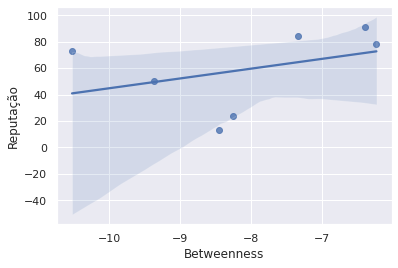

In [81]:
plot(sb)

In [83]:
reg_summary(sb)

/usr/local/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              reputacao   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                 -0.029
Method:                 Least Squares   F-statistic:                    0.8313
Date:                Mon, 29 Nov 2021   Prob (F-statistic):              0.404
Time:                        22:40:05   Log-Likelihood:                -32.808
No. Observations:                   7   AIC:                             69.62
Df Residuals:                       5   BIC:                             69.51
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             118.8629     66.697      1.782      0.135     -52.588     290.314
np.log(betweenness)     7.4094      8.126      0.912      0.404     -13.480      28.299
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.788
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.756
Skew:                          -0.561   Prob(JB):                        0.685
Kurtosis:                       1.845   Cond. No.                         47.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

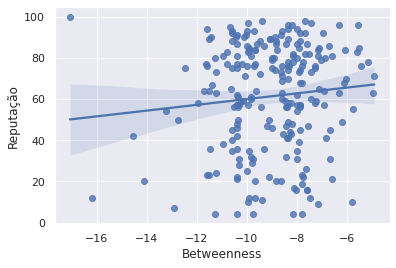

In [38]:
plot(mb)

In [39]:
reg_summary(mb)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              reputacao   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.276
Date:                Mon, 29 Nov 2021   Prob (F-statistic):              0.133
Time:                        22:29:44   Log-Likelihood:                -1077.1
No. Observations:                 231   AIC:                             2158.
Df Residuals:                     229   BIC:                             2165.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              73.9532      8.523      8.676      0.000      57.159      90.748
np.log(betweenness)     1.3951      0.925      1.509      0.133      -0.427       3.217
==============================================================================
Omnibus:                       21.547   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.727
Skew:                          -0.558   Prob(JB):                     0.000233
Kurtosis:                       2.299   Cond. No.                         46.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Betweenness + Clustering + Degree**

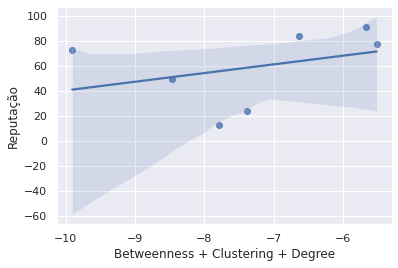

In [40]:
sb_x = np.log(sb['betweenness']) + sb['clustering'] + sb['degree']
plot(sb, x=sb_x, xlabel="Betweenness + Clustering + Degree")

In [41]:
reg_summary(sb, formula='reputacao ~ np.log(betweenness) + clustering + degree')

/usr/local/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              reputacao   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                 -0.221
Method:                 Least Squares   F-statistic:                    0.6377
Date:                Mon, 29 Nov 2021   Prob (F-statistic):              0.640
Time:                        22:29:44   Log-Likelihood:                -31.620
No. Observations:                   7   AIC:                             71.24
Df Residuals:                       3   BIC:                             71.02
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              64.7152    202.323      0.320      0.770    -579.166     708.596
np.log(betweenness)    -7.6782     20.615     -0.372      0.734     -73.285      57.929
clustering           -143.2919    145.807     -0.983      0.398    -607.316     320.732
degree                281.5961    485.912      0.580      0.603   -1264.792    1827.984
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.925
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.447
Skew:                          -0.284   Prob(JB):                        0.800
Kurtosis:                       1.900   Cond. No.                         337.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Análise breve:**
- Coeficiente (logarítmico) considerável relacionando _betweenness_ e reputação;
- p-valor pequeno, indicando que podemos desprezar a hipótese nula (não há relação);

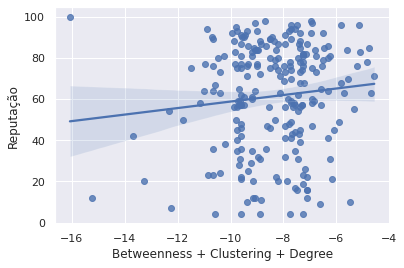

In [42]:
mb_x = np.log(mb['betweenness']) + mb['clustering'] + mb['degree']
plot(mb, x=mb_x, xlabel="Betweenness + Clustering + Degree")

In [43]:
reg_summary(mb, formula='reputacao ~ np.log(betweenness) + clustering + degree')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              reputacao   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.458
Date:                Mon, 29 Nov 2021   Prob (F-statistic):              0.227
Time:                        22:29:44   Log-Likelihood:                -1076.0
No. Observations:                 231   AIC:                             2160.
Df Residuals:                     227   BIC:                             2174.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              77.1184     10.872      7.093      0.000      55.695      98.542
np.log(betweenness)     3.1126      1.559      1.996      0.047       0.040       6.185
clustering             21.9443     15.158      1.448      0.149      -7.923      51.812
degree                -34.3026    102.889     -0.333      0.739    -237.042     168.437
==============================================================================
Omnibus:                       20.831   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.952
Skew:                          -0.540   Prob(JB):                     0.000344
Kurtosis:                       2.301   Cond. No.                         566.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 2.2 Depois do Streaming

In [44]:
sa = saws[saws['betweenness'] > 0]
ma = maws[maws['betweenness'] > 0]

In [45]:
sa.head()

,nome,id,_x,_y,betweenness,clustering,degree,reputacao
20,Ace Attorney,162,69.000390,129.286482,3.078296e-04,0.666102,0.032573,66.0
77,Detention,456,41.970713,105.062297,6.740289e-08,0.969697,0.006515,41.0
200,About Time,1114,26.869118,47.111411,2.947610e-05,0.724696,0.021173,69.0
201,I See You,1124,44.899443,124.645347,2.818128e-04,0.596687,0.038002,79.0
668,The Hateful Eight: Extended Version,2846,56.528794,149.140820,2.814182e-06,0.964847,0.025516,74.0


In [46]:
ma.head()

,nome,id,_x,_y,betweenness,clustering,degree,reputacao
27,Ride Your Wave,62,44.678612,36.371525,0.001306,0.514924,0.030860,93.0
75,Trolls World Tour,161,63.218041,34.246239,0.000035,0.707874,0.039029,70.0
104,On Happiness Road,219,54.269257,40.908359,0.000006,0.884973,0.026095,100.0
137,Lizzie,290,45.374297,150.648035,0.000353,0.659371,0.019514,66.0
139,High Life,294,37.449815,98.575814,0.000313,0.364760,0.026095,82.0


**Betweenness isolado**

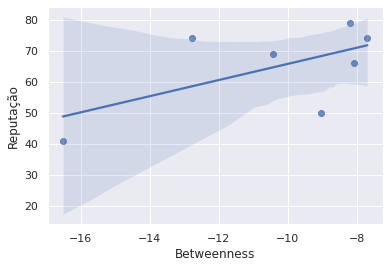

In [47]:
plot(sa)

In [48]:
reg_summary(sa)

/usr/local/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              reputacao   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     2.807
Date:                Mon, 29 Nov 2021   Prob (F-statistic):              0.155
Time:                        22:29:45   Log-Likelihood:                -26.305
No. Observations:                   7   AIC:                             56.61
Df Residuals:                       5   BIC:                             56.50
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              91.7131     16.768      5.470      0.003      48.609     134.817
np.log(betweenness)     2.5993      1.551      1.675      0.155      -1.389       6.587
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.367
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.278
Skew:                          -0.280   Prob(JB):                        0.870
Kurtosis:                       2.199   Cond. No.                         39.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

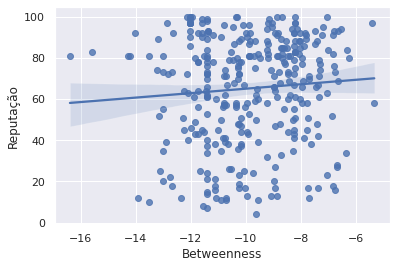

In [49]:
plot(ma)

In [50]:
reg_summary(ma)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              reputacao   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.018
Date:                Mon, 29 Nov 2021   Prob (F-statistic):              0.156
Time:                        22:29:45   Log-Likelihood:                -1540.8
No. Observations:                 330   AIC:                             3086.
Df Residuals:                     328   BIC:                             3093.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              75.8572      7.649      9.917      0.000      60.810      90.905
np.log(betweenness)     1.0809      0.761      1.420      0.156      -0.416       2.578
==============================================================================
Omnibus:                       33.625   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.222
Skew:                          -0.592   Prob(JB):                     2.02e-06
Kurtosis:                       2.290   Cond. No.                         54.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Betweenness + Clustering + Degree**

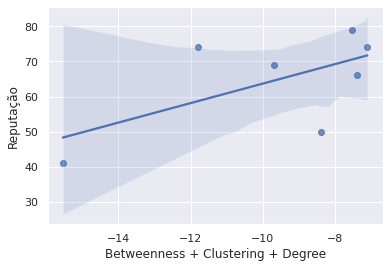

In [51]:
sa_x = np.log(sa['betweenness']) + sa['clustering'] + sa['degree']
plot(sa, x=sa_x, xlabel="Betweenness + Clustering + Degree")

In [52]:
reg_summary(sa, formula='reputacao ~ np.log(betweenness) + clustering + degree')

/usr/local/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              reputacao   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     1.391
Date:                Mon, 29 Nov 2021   Prob (F-statistic):              0.396
Time:                        22:29:46   Log-Likelihood:                -24.814
No. Observations:                   7   AIC:                             57.63
Df Residuals:                       3   BIC:                             57.41
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              74.8798     75.650      0.990      0.395    -165.871     315.630
np.log(betweenness)     7.7637      5.854      1.326      0.277     -10.866      26.394
clustering             99.1877     78.576      1.262      0.296    -150.877     349.252
degree                -47.5019   1106.874     -0.043      0.968   -3570.070    3475.066
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.905
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.743
Skew:                          -0.507   Prob(JB):                        0.690
Kurtosis:                       1.768   Cond. No.                     2.49e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

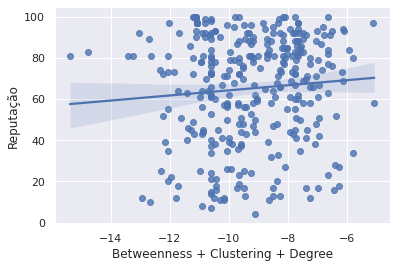

In [53]:
ma_x = np.log(ma['betweenness']) + ma['clustering'] + ma['degree']
plot(ma, x=ma_x, xlabel="Betweenness + Clustering + Degree")

In [54]:
reg_summary(ma, formula='reputacao ~ np.log(betweenness) + clustering + degree')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              reputacao   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.494
Date:                Mon, 29 Nov 2021   Prob (F-statistic):             0.0600
Time:                        22:29:46   Log-Likelihood:                -1538.1
No. Observations:                 330   AIC:                             3084.
Df Residuals:                     326   BIC:                             3099.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              69.7102      8.713      8.000      0.000      52.569      86.852
np.log(betweenness)     1.3593      1.205      1.128      0.260      -1.012       3.731
clustering              7.3276     11.735      0.624      0.533     -15.758      30.413
degree                206.9970     99.196      2.087      0.038      11.853     402.141
==============================================================================
Omnibus:                       31.533   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.145
Skew:                          -0.582   Prob(JB):                     3.47e-06
Kurtosis:                       2.311   Cond. No.                         709.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Análise breve:**
- Coeficiente (logarítmico) considerável relacionando _betweenness_ e reputação;
- p-valor pequeno, indicando que podemos desprezar a hipótese nula (não há relação);

---

**O que mudou no antes/depois (supondo que há relação)**

Ambos os parâmetros analisados (coeficiente e p-valor) diminuíram entre os dois períodos. A Diminuição do coeficiente pode indicar que a relação entre __betweenness__ e __reputação__ foi enfraquecida com o aumento da popularização do Streaming. Por outro lado, observando a variação do p-valor, é possível que a relação seja mais confiável.
